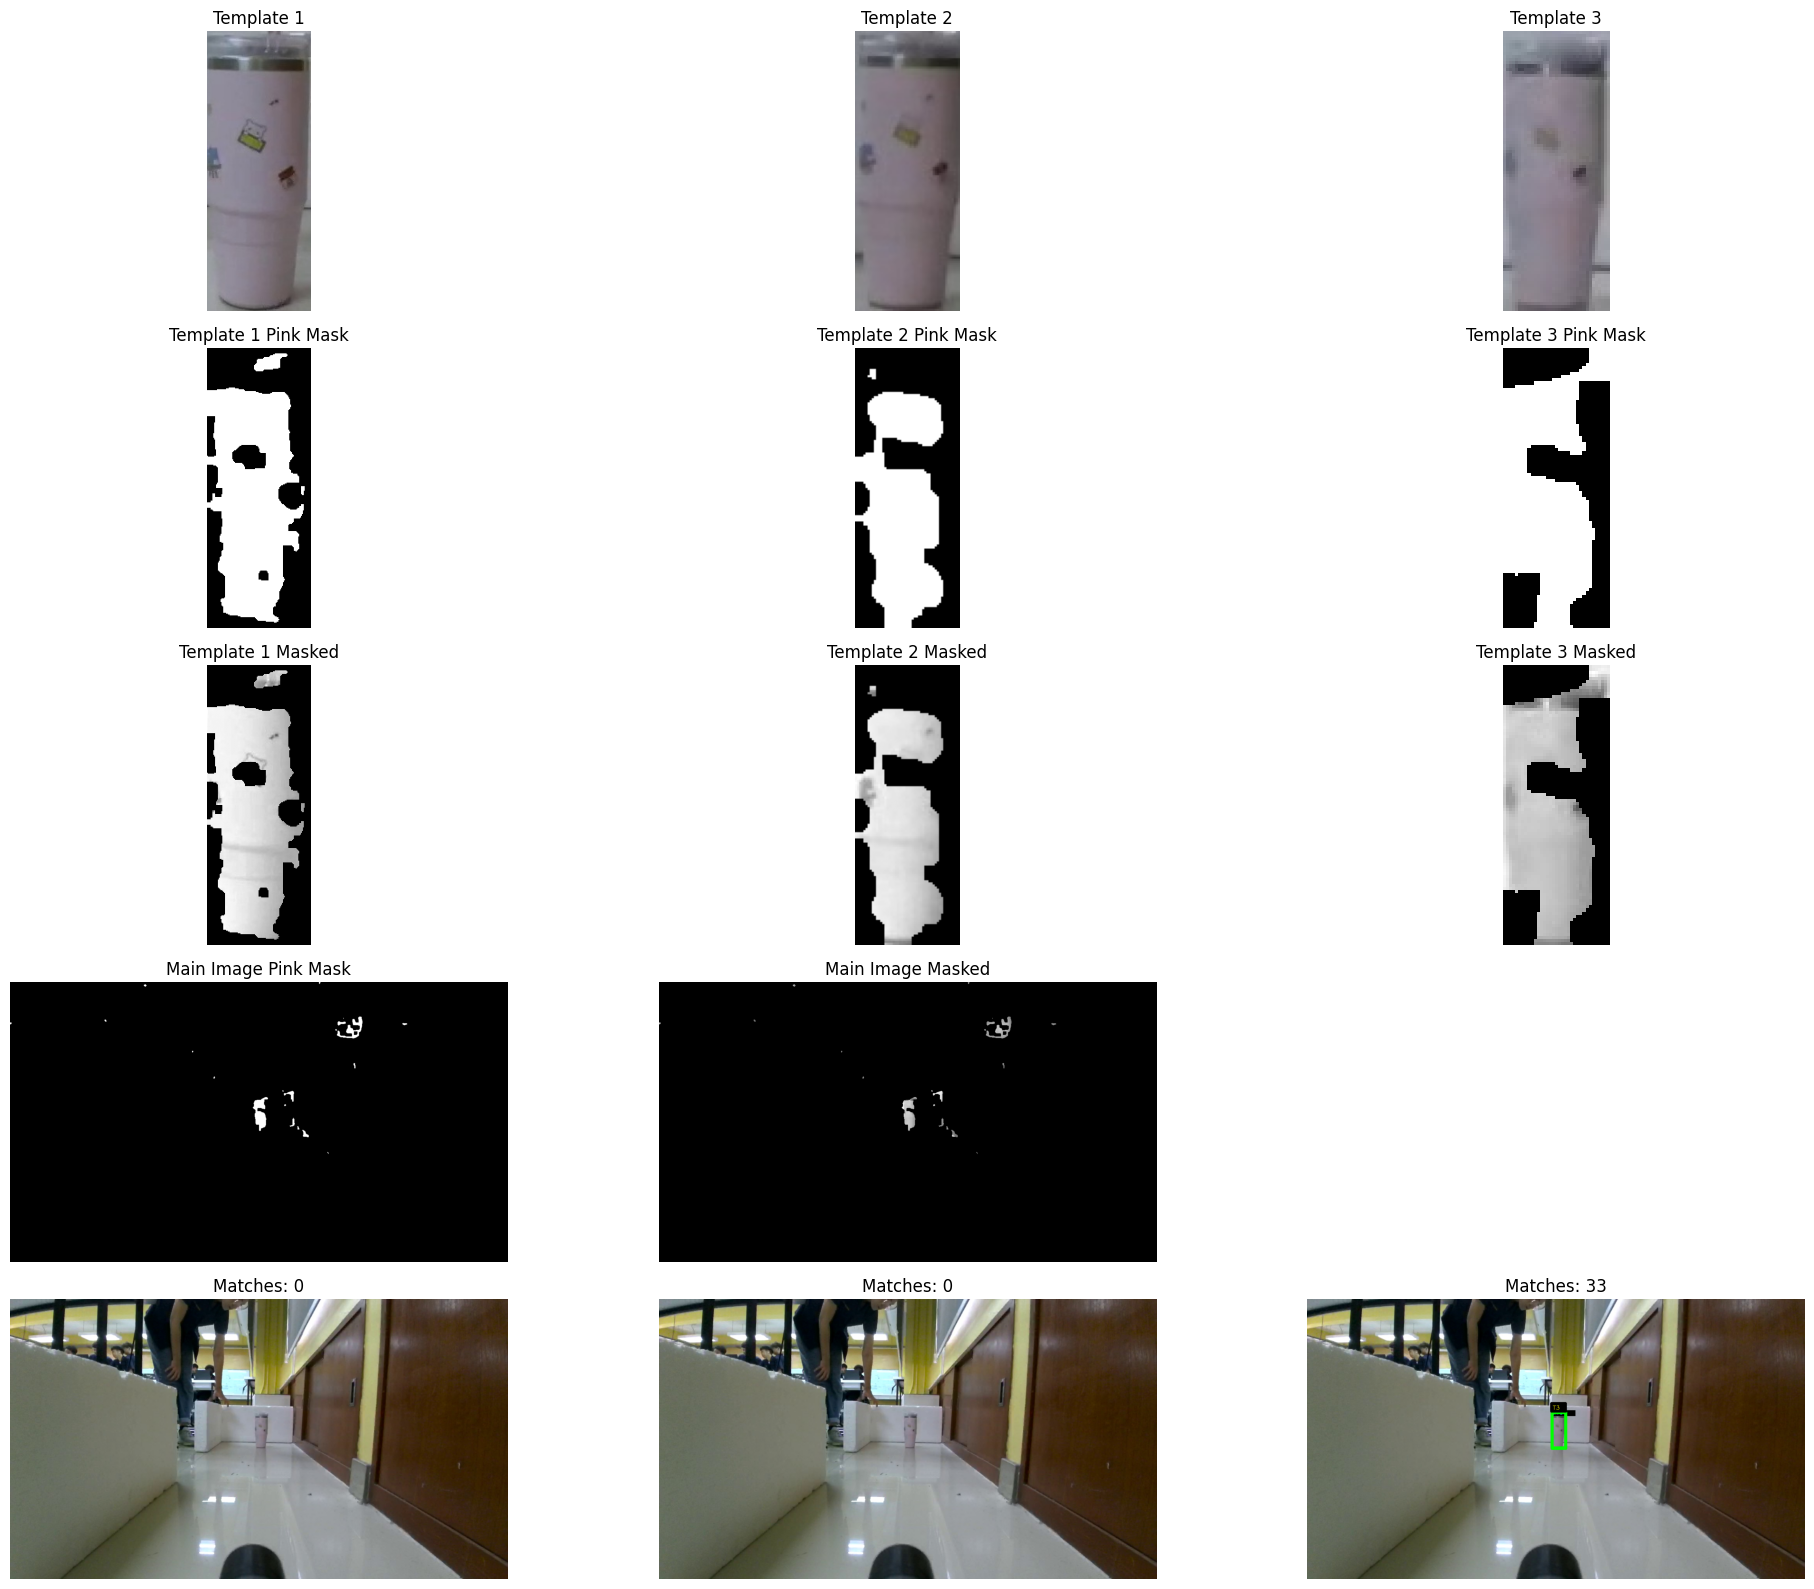

=== Template Matching with Pink Mask Results ===
Template 1: พบ 0 ตำแหน่ง
Template 2: พบ 0 ตำแหน่ง
Template 3: พบ 33 ตำแหน่ง

Threshold ที่ใช้: 0.7
Pink mask ถูกใช้เพื่อมุ่งเน้นเฉพาะพื้นที่สีชมพูในการค้นหา
ช่วยลด false positive และเพิ่มความแม่นยำในการ matching

=== Detection Details ===

Template 1: ไม่พบการตรวจจับ

Template 2: ไม่พบการตรวจจับ

Template 3:
  Detection 1: x=629, y=288, w=35, h=92
    Confidence: 0.728
  Detection 2: x=630, y=288, w=35, h=92
    Confidence: 0.718
  Detection 3: x=628, y=289, w=35, h=92
    Confidence: 0.742
  Detection 4: x=629, y=289, w=35, h=92
    Confidence: 0.779
  Detection 5: x=630, y=289, w=35, h=92
    Confidence: 0.767
  Detection 6: x=631, y=289, w=35, h=92
    Confidence: 0.738
  Detection 7: x=627, y=290, w=35, h=92
    Confidence: 0.717
  Detection 8: x=628, y=290, w=35, h=92
    Confidence: 0.785
  Detection 9: x=629, y=290, w=35, h=92
    Confidence: 0.826
  Detection 10: x=630, y=290, w=35, h=92
    Confidence: 0.809
  Detection 11: x=63

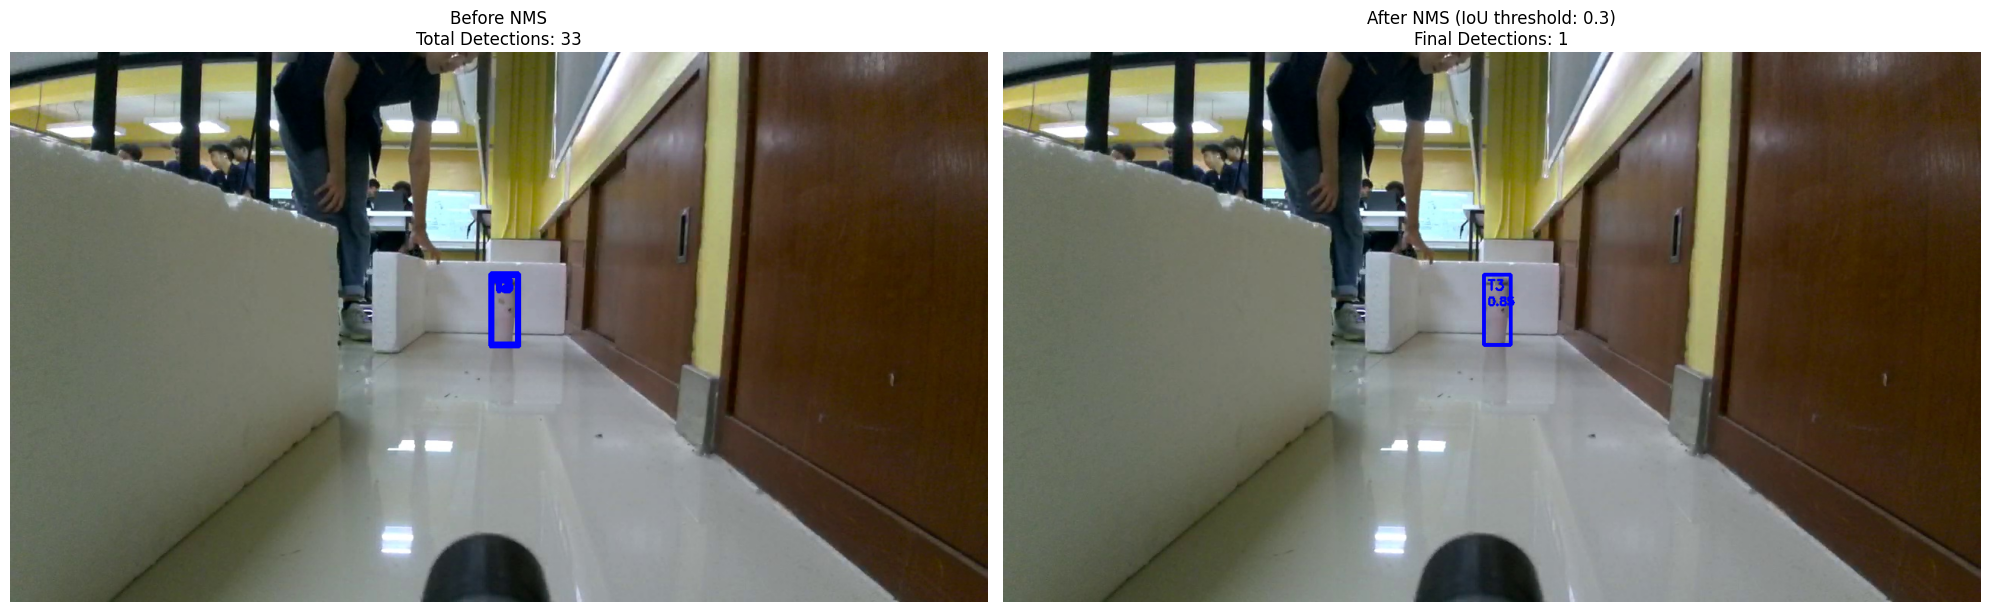

=== Non-Maximum Suppression Details ===
IoU Threshold: 0.3
Detections before NMS: 33
Detections after NMS: 1
Removed overlapping boxes: 32

=== Final Detection Results ===
Detection 1: Template T3
  Position: x=629, y=291, w=35, h=92
  Confidence: 0.848
  Color: (0, 0, 255)


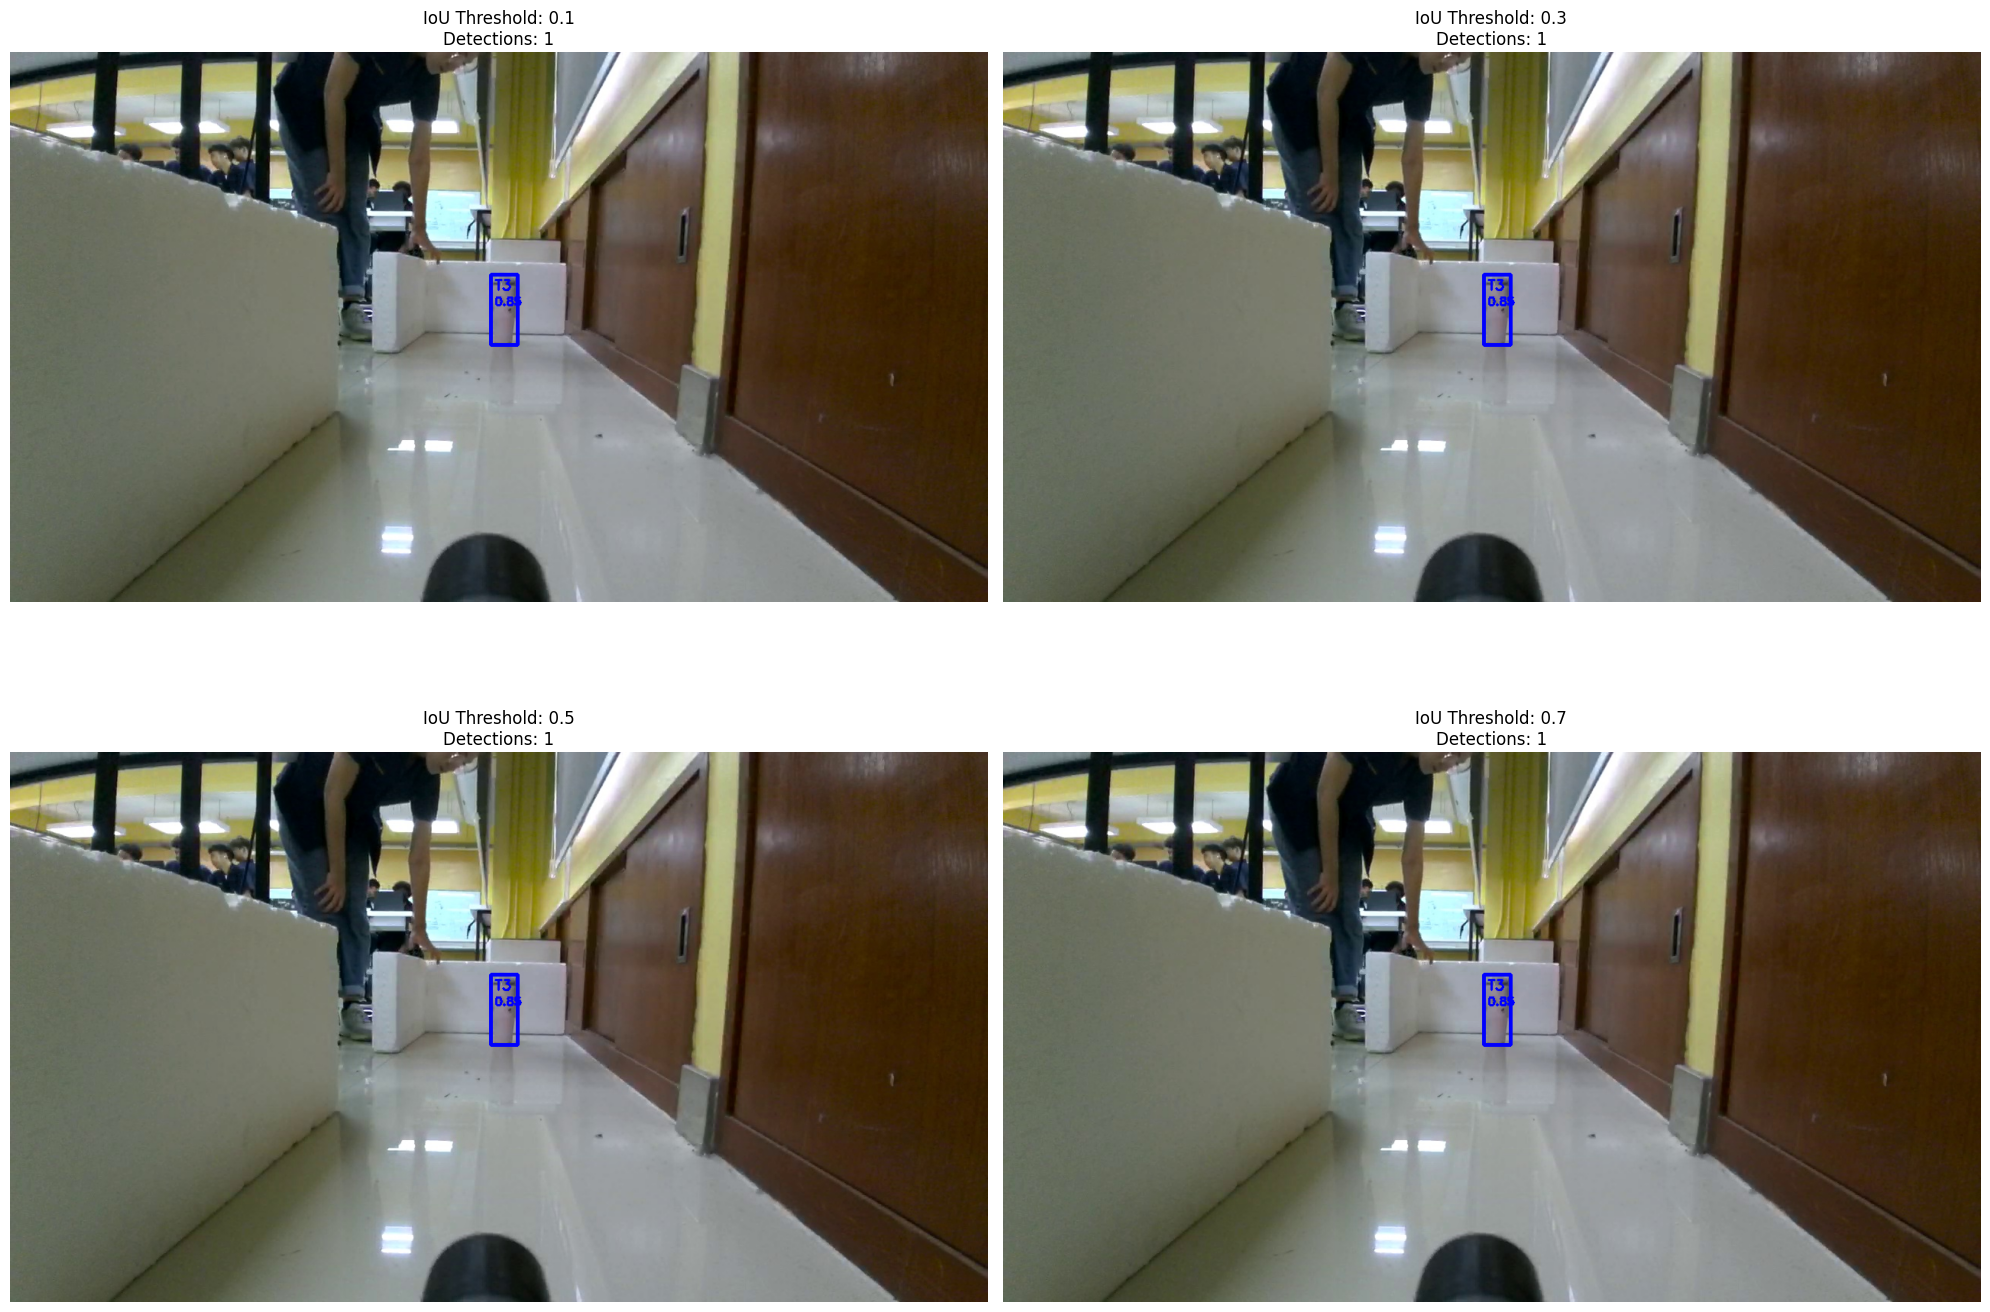

=== IoU Threshold Comparison ===
IoU 0.1: 1 detections
IoU 0.3: 1 detections
IoU 0.5: 1 detections
IoU 0.7: 1 detections


In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# 1. โหลดภาพหลักและแปลงเป็น RGB
# ------------------------------
image = cv2.imread("../../../image/capture_1756180115.jpg")
if image is None:
    raise FileNotFoundError("main_image.jpg not found")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# ------------------------------
# 2. ฟังก์ชันสร้าง Pink Mask (ปรับปรุงจาก detect_object.ipynb)
# ------------------------------
def create_pink_mask(img_rgb):
    """สร้าง mask สำหรับสีชมพู โดยใช้ HSV color space"""
    # แปลงเป็น HSV เพื่อจับสีชมพูได้ดีกว่า
    img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    
    # ช่วงค่าต่ำสุด ของสีชมพู (ปรับจาก detect_object.ipynb)
    lower_pink = np.array([120, 20, 80])
    # ช่วงค่าสูงสุด ของสีชมพู
    upper_pink = np.array([170, 100, 200])
    
    # สร้าง mask
    mask = cv2.inRange(hsv, lower_pink, upper_pink)
    
    # เพิ่มการ morphology เพื่อลด noise (จาก detect_object.ipynb)
    mask = cv2.medianBlur(mask, 5)
    kernel = np.ones((7, 7), np.uint8)
    # ปิดช่องว่างเล็กๆ
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

# สร้าง pink mask สำหรับภาพหลัก
main_pink_mask = create_pink_mask(image_rgb)

# แปลงภาพหลักเป็น grayscale และใช้ mask
main_gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
main_masked = cv2.bitwise_and(main_gray, main_gray, mask=main_pink_mask)

# ------------------------------
# 3. โหลด template และเตรียม mask + grayscale
# ------------------------------
template1 = "../../../image/template/template_pic1_x_573_y_276_w_115_h_312.jpg"
template2 = "../../../image/template/template_pic2_x_634_y_291_w_50_h_134.jpg"
template3 = "../../../image/template/template_pic3_x_629_y_291_w_35_h_92.jpg"

template_files = [template1, template2, template3]
templates_masked = []
templates_rgb = []
templates_masks = []

for f in template_files:
    tmpl = cv2.imread(f)
    if tmpl is None:
        raise FileNotFoundError(f"{f} not found")
    
    tmpl_rgb = cv2.cvtColor(tmpl, cv2.COLOR_BGR2RGB)
    templates_rgb.append(tmpl_rgb)
    
    # สร้าง pink mask สำหรับ template
    tmpl_pink_mask = create_pink_mask(tmpl_rgb)
    templates_masks.append(tmpl_pink_mask)
    
    # แปลงเป็น grayscale และใช้ mask
    tmpl_gray = cv2.cvtColor(tmpl_rgb, cv2.COLOR_RGB2GRAY)
    tmpl_masked = cv2.bitwise_and(tmpl_gray, tmpl_gray, mask=tmpl_pink_mask)
    
    templates_masked.append(tmpl_masked)

# ------------------------------
# 4. ฟังก์ชันทำ Template Matching สำหรับ masked grayscale
# ------------------------------
def match_template_masked(img_masked, tmpl_masked, threshold=0.8):
    """Template matching บน masked grayscale images"""
    result = cv2.matchTemplate(img_masked, tmpl_masked, cv2.TM_CCOEFF_NORMED)
    
    # หา location ที่ score >= threshold
    locations = np.where(result >= threshold)
    
    boxes = []
    h, w = tmpl_masked.shape
    
    for pt in zip(*locations[::-1]):  # แปลง (row, col) -> (x, y)
        boxes.append((pt, (pt[0]+w, pt[1]+h)))
    
    return boxes, result

# ------------------------------
# 5. ทำ matching สำหรับทุก template - แก้ไขการวาดข้อความ
# ------------------------------
threshold = 0.7
matched_results = []

for i, tmpl_masked in enumerate(templates_masked):
    boxes, result = match_template_masked(main_masked, tmpl_masked, threshold)
    
    # วาดกรอบบนภาพต้นฉบับ (RGB)
    img_copy = image_rgb.copy()
    for j, (top_left, bottom_right) in enumerate(boxes):
        # วาดกรอบสีเขียว
        cv2.rectangle(img_copy, top_left, bottom_right, (0, 255, 0), 2)
        
        # คำนวณตำแหน่งข้อความให้ไม่ล้นออกนอกภาพ
        text_x = max(5, top_left[0])  # ไม่ให้ติดขอบซ้าย
        text_y = max(25, top_left[1] - 5)  # ไม่ให้ติดขอบบน
        
        # ตรวจสอบว่าข้อความจะล้นออกขวาหรือไม่
        img_height, img_width = img_copy.shape[:2]
        if text_x > img_width - 50:  # ถ้าใกล้ขอบขวา
            text_x = bottom_right[0] - 50
        
        # วาดข้อความด้วยสีเหลือง (ไม่ใช่แดง) และเพิ่ม background
        # วาดพื้นหลังสีดำให้ข้อความ
        cv2.rectangle(img_copy, (text_x-2, text_y-18), (text_x+35, text_y+2), (0, 0, 0), -1)
        # วาดข้อความสีเหลือง
        cv2.putText(img_copy, f"T{i+1}", (text_x, text_y-5), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 1)
        
        # เพิ่มข้อมูล confidence score (ถ้าต้องการ)
        if j == 0:  # แสดงเฉพาะตัวแรก
            conf_y = text_y + 15
            confidence = result[top_left[1], top_left[0]] if top_left[1] < result.shape[0] and top_left[0] < result.shape[1] else 0
            cv2.rectangle(img_copy, (text_x-2, conf_y-12), (text_x+60, conf_y+2), (0, 0, 0), -1)
            cv2.putText(img_copy, f"{confidence:.2f}", (text_x, conf_y-2), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 255), 1)
    
    matched_results.append((img_copy, templates_rgb[i], len(boxes)))

# ------------------------------
# 6. แสดงผลด้วย subplot (เพิ่ม mask visualization)
# ------------------------------
plt.figure(figsize=(20, 16))

# แถวที่ 1: Templates
for i, (img_res, tmpl_res, n_boxes) in enumerate(matched_results):
    plt.subplot(5, len(matched_results), i+1)
    plt.imshow(tmpl_res)
    plt.title(f"Template {i+1}")
    plt.axis("off")

# แถวที่ 2: Template masks
for i, tmpl_mask in enumerate(templates_masks):
    plt.subplot(5, len(matched_results), i+1+len(matched_results))
    plt.imshow(tmpl_mask, cmap='gray')
    plt.title(f"Template {i+1} Pink Mask")
    plt.axis("off")

# แถวที่ 3: Template masked (grayscale with mask applied)
for i, tmpl_masked in enumerate(templates_masked):
    plt.subplot(5, len(matched_results), i+1+2*len(matched_results))
    plt.imshow(tmpl_masked, cmap='gray')
    plt.title(f"Template {i+1} Masked")
    plt.axis("off")

# แถวที่ 4: Main image mask (แสดงเฉพาะรูปแรก)
plt.subplot(5, len(matched_results), 1+3*len(matched_results))
plt.imshow(main_pink_mask, cmap='gray')
plt.title("Main Image Pink Mask")
plt.axis("off")

plt.subplot(5, len(matched_results), 2+3*len(matched_results))
plt.imshow(main_masked, cmap='gray')
plt.title("Main Image Masked")
plt.axis("off")

# แถวที่ 5: ผล matching บนภาพ
for i, (img_res, tmpl_res, n_boxes) in enumerate(matched_results):
    plt.subplot(5, len(matched_results), i+1+4*len(matched_results))
    plt.imshow(img_res)
    plt.title(f"Matches: {n_boxes}")
    plt.axis("off")

plt.tight_layout()
plt.show()

# ------------------------------
# 7. แสดงผลสรุป
# ------------------------------
print("=== Template Matching with Pink Mask Results ===")
for i, (_, _, n_boxes) in enumerate(matched_results):
    print(f"Template {i+1}: พบ {n_boxes} ตำแหน่ง")

print(f"\nThreshold ที่ใช้: {threshold}")
print("Pink mask ถูกใช้เพื่อมุ่งเน้นเฉพาะพื้นที่สีชมพูในการค้นหา")
print("ช่วยลด false positive และเพิ่มความแม่นยำในการ matching")

# ------------------------------
# 8. ฟังก์ชันเพิ่มเติม: แสดงรายละเอียดการตรวจจับ
# ------------------------------
def show_detection_details():
    """แสดงรายละเอียดของการตรวจจับแต่ละ template"""
    print("\n=== Detection Details ===")
    
    for i, tmpl_masked in enumerate(templates_masked):
        boxes, result = match_template_masked(main_masked, tmpl_masked, threshold)
        
        if len(boxes) > 0:
            print(f"\nTemplate {i+1}:")
            for j, (top_left, bottom_right) in enumerate(boxes):
                x, y = top_left
                w = bottom_right[0] - top_left[0]
                h = bottom_right[1] - top_left[1]
                print(f"  Detection {j+1}: x={x}, y={y}, w={w}, h={h}")
                
                # คำนวณ confidence score ที่ตำแหน่งนั้น
                confidence = result[y, x] if y < result.shape[0] and x < result.shape[1] else 0
                print(f"    Confidence: {confidence:.3f}")
        else:
            print(f"\nTemplate {i+1}: ไม่พบการตรวจจับ")

show_detection_details()

# ------------------------------
# 9. Non-Maximum Suppression (NMS) เพื่อลดการทับซ้อน
# ------------------------------
def calculate_iou(box1, box2):
    """คำนวณ Intersection over Union (IoU) ระหว่าง 2 กรอบ"""
    # box format: ((x1, y1), (x2, y2))
    x1_1, y1_1 = box1[0]
    x2_1, y2_1 = box1[1]
    x1_2, y1_2 = box2[0]
    x2_2, y2_2 = box2[1]
    
    # หาพื้นที่ทับซ้อน (intersection)
    x1_i = max(x1_1, x1_2)
    y1_i = max(y1_1, y1_2)
    x2_i = min(x2_1, x2_2)
    y2_i = min(y2_1, y2_2)
    
    if x2_i <= x1_i or y2_i <= y1_i:
        return 0.0
    
    intersection_area = (x2_i - x1_i) * (y2_i - y1_i)
    
    # หาพื้นที่รวม (union)
    area1 = (x2_1 - x1_1) * (y2_1 - y1_1)
    area2 = (x2_2 - x1_2) * (y2_2 - y1_2)
    union_area = area1 + area2 - intersection_area
    
    return intersection_area / union_area if union_area > 0 else 0.0

def non_maximum_suppression(boxes_with_scores, iou_threshold=0.5):
    """Non-Maximum Suppression เพื่อกำจัดกรอบที่ทับซ้อน"""
    if len(boxes_with_scores) == 0:
        return []
    
    # เรียงตาม confidence score (จากมากไปน้อย)
    boxes_with_scores.sort(key=lambda x: x[2], reverse=True)
    
    selected_boxes = []
    
    while len(boxes_with_scores) > 0:
        # เลือกกรอบที่มี confidence สูงสุด
        current_box = boxes_with_scores.pop(0)
        selected_boxes.append(current_box)
        
        # กำจัดกรอบที่มี IoU สูงเกินไปกับกรอบที่เลือก
        boxes_with_scores = [
            box for box in boxes_with_scores
            if calculate_iou(current_box[:2], box[:2]) < iou_threshold
        ]
    
    return selected_boxes

def apply_nms_to_all_templates(iou_threshold=0.3):
    """ใช้ NMS กับผลลัพธ์จากทุก template"""
    all_detections = []
    colors = [(0, 255, 0), (255, 165, 0), (0, 0, 255)]  # เขียว, ส้ม, น้ำเงิน
    
    # รวบรวมการตรวจจับทั้งหมด
    for i, tmpl_masked in enumerate(templates_masked):
        boxes, result = match_template_masked(main_masked, tmpl_masked, threshold)
        
        for box in boxes:
            top_left, bottom_right = box
            # คำนวณ confidence score
            confidence = result[top_left[1], top_left[0]] if top_left[1] < result.shape[0] and top_left[0] < result.shape[1] else 0
            
            # เก็บข้อมูล: (top_left, bottom_right, confidence, template_id, color)
            all_detections.append((top_left, bottom_right, confidence, i+1, colors[i % len(colors)]))
    
    # ใช้ NMS กับการตรวจจับทั้งหมด
    nms_detections = non_maximum_suppression(all_detections, iou_threshold)
    
    return nms_detections

# ------------------------------
# 10. สร้างภาพผลลัพธ์ที่ผ่าน NMS
# ------------------------------
def create_final_result_images(iou_threshold=0.3):
    """สร้างภาพเปรียบเทียบก่อนและหลัง NMS"""
    
    # ภาพก่อน NMS (ทับซ้อนกัน)
    img_before = image_rgb.copy()
    colors = [(0, 255, 0), (255, 165, 0), (0, 0, 255)]
    total_boxes_before = 0
    
    for i, tmpl_masked in enumerate(templates_masked):
        boxes, result = match_template_masked(main_masked, tmpl_masked, threshold)
        total_boxes_before += len(boxes)
        
        for top_left, bottom_right in boxes:
            color = colors[i % len(colors)]
            cv2.rectangle(img_before, top_left, bottom_right, color, 2)
            # เพิ่มหมายเลข template
            cv2.putText(img_before, f"T{i+1}", 
                       (top_left[0]+5, top_left[1]+20), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    
    # ภาพหลัง NMS (ไม่ทับซ้อน)
    img_after = image_rgb.copy()
    nms_detections = apply_nms_to_all_templates(iou_threshold)
    
    for detection in nms_detections:
        top_left, bottom_right, confidence, template_id, color = detection
        
        # วาดกรอบ
        cv2.rectangle(img_after, top_left, bottom_right, color, 3)
        
        # วาดข้อความ template ID
        cv2.putText(img_after, f"T{template_id}", 
                   (top_left[0]+5, top_left[1]+20), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
        
        # วาด confidence score
        cv2.putText(img_after, f"{confidence:.2f}", 
                   (top_left[0]+5, top_left[1]+40), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    
    return img_before, img_after, total_boxes_before, len(nms_detections)

# สร้างภาพเปรียบเทียบ
img_before_nms, img_after_nms, count_before, count_after = create_final_result_images(iou_threshold=0.3)

# แสดงผลเปรียบเทียบ
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(img_before_nms)
plt.title(f"Before NMS\nTotal Detections: {count_before}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_after_nms)
plt.title(f"After NMS (IoU threshold: 0.3)\nFinal Detections: {count_after}")
plt.axis('off')

plt.tight_layout()
plt.show()

# ------------------------------
# 11. แสดงรายละเอียดการทำ NMS
# ------------------------------
def show_nms_details():
    """แสดงรายละเอียดของ NMS process"""
    print("=== Non-Maximum Suppression Details ===")
    
    nms_detections = apply_nms_to_all_templates(iou_threshold=0.3)
    
    print(f"IoU Threshold: 0.3")
    print(f"Detections before NMS: {count_before}")
    print(f"Detections after NMS: {count_after}")
    print(f"Removed overlapping boxes: {count_before - count_after}")
    
    print(f"\n=== Final Detection Results ===")
    for i, detection in enumerate(nms_detections):
        top_left, bottom_right, confidence, template_id, color = detection
        x, y = top_left
        w = bottom_right[0] - top_left[0]
        h = bottom_right[1] - top_left[1]
        
        print(f"Detection {i+1}: Template T{template_id}")
        print(f"  Position: x={x}, y={y}, w={w}, h={h}")
        print(f"  Confidence: {confidence:.3f}")
        print(f"  Color: {color}")

show_nms_details()

# ------------------------------
# 12. ทดสอบ IoU threshold ต่างๆ
# ------------------------------
def compare_iou_thresholds():
    """เปรียบเทียบผลลัพธ์ที่ IoU threshold ต่างๆ"""
    thresholds = [0.1, 0.3, 0.5, 0.7]
    
    plt.figure(figsize=(20, 15))
    
    for i, iou_thresh in enumerate(thresholds):
        _, img_result, _, final_count = create_final_result_images(iou_thresh)
        
        plt.subplot(2, 2, i+1)
        plt.imshow(img_result)
        plt.title(f"IoU Threshold: {iou_thresh}\nDetections: {final_count}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("=== IoU Threshold Comparison ===")
    for iou_thresh in thresholds:
        nms_result = apply_nms_to_all_templates(iou_thresh)
        print(f"IoU {iou_thresh}: {len(nms_result)} detections")

compare_iou_thresholds()